In [105]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from data.make_dataset import ESDCData
from py_esdc.data import window_xy, get_xy_indices
from kernellib.dependence import HSIC, RHSIC

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extract ESDC Data

In [2]:
!ls /media/disk/databases/BACI-CABLAB/low_res_data/


aerosol_optical_thickness_550  latent_energy
aerosol_optical_thickness_555  net_ecosystem_exchange
aerosol_optical_thickness_659  open_water_evaporation
aerosol_optical_thickness_865  ozone
air_temperature_2m	       potential_evaporation
bare_soil_evaporation	       precipitation
black_sky_albedo	       root_moisture
burnt_area		       sensible_heat
c_emissions		       snow_sublimation
country_mask		       snow_water_equivalent
evaporation		       soil_moisture
evaporative_stress	       surface_moisture
fractional_snow_cover	       terrestrial_ecosystem_respiration
gross_primary_productivity     transpiration
interception_loss	       water_mask
land_surface_temperature       water_vapour


In [3]:
!ls /media/disk/databases/BACI-CABLAB/low_res_data/water_mask

2001_water_mask.nc


In [4]:
# variables for the experiment
variables = [
    'gross_primary_productivity',
    'land_surface_temperature',
    'air_temperature_2m',
]

start_time = '2010'
end_time = '2010'
subsection = 'europe'
data_path = '/media/disk/databases/BACI-CABLAB/low_res_data/'
minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/nb_data/'

In [5]:


# Initialize data class
esdc_data = ESDCData(
    variables=variables,
    time_frame=[start_time, end_time],
    subsection=subsection,
    minicube_path=minicube_path
)

# Extract data
data = esdc_data.extract_datacube()

In [61]:
data

<xarray.Dataset>
Dimensions:                     (bnds: 2, lat: 144, lon: 312, time: 46)
Coordinates:
  * time                        (time) datetime64[ns] 2010-01-05 ... 2010-12-31
  * lon                         (lon) float32 -17.875 -17.625 ... 59.625 59.875
  * lat                         (lat) float32 71.375 71.125 ... 35.875 35.625
    mask                        (lat, lon) float32 2.0 2.0 2.0 ... 1.0 1.0 1.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<shape=(46, 2), chunksize=(46, 2)>
    lon_bnds                    (time, lon, bnds) float32 dask.array<shape=(46, 312, 2), chunksize=(46, 312, 2)>
    lat_bnds                    (time, lat, bnds) float32 dask.array<shape=(46, 144, 2), chunksize=(46, 144, 2)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(46, 144, 312), chunksize=(46, 144, 312)>
    land_surface_temperature    (time, lat, lon) float32 dask.array<shape=(46, 14

In [7]:
(data.gross_primary_productivity)

<xarray.DataArray 'gross_primary_productivity' (time: 46, lat: 144, lon: 312)>
dask.array<shape=(46, 144, 312), dtype=float32, chunksize=(46, 144, 312)>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-05 2010-01-13 ... 2010-12-31
  * lon      (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat      (lat) float32 71.375 71.125 70.875 70.625 ... 36.125 35.875 35.625
    mask     (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    url:            http://www.fluxcom.org/
    standard_name:  gross_primary_productivity_of_carbon
    units:          gC m-2 day-1
    long_name:      Gross Primary Productivity
    source_name:    GPPall
    references:     Tramontana, Gianluca, et al. "Predicting carbon dioxide a...

In [188]:
# Extract summertime months
subset = data.sel(time=slice('2010-06', '2010-08'))

# Take GPP and land surface temperature
gpp_data = subset.gross_primary_productivity.where(subset.mask==1)
lst_data = subset.land_surface_temperature.where(subset.mask==1)

n_time, n_lat, n_lon = gpp_data.shape

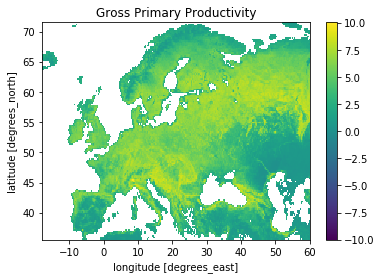

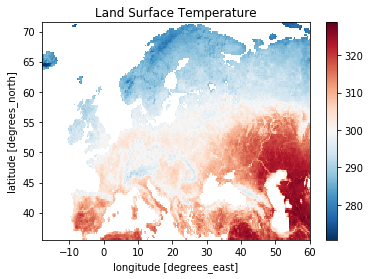

In [191]:
fig, ax = plt.subplots()

gpp_data.mean(dim='time', skipna=True).plot.imshow(ax=ax, cmap='viridis', robust=False)
ax.set_title('Gross Primary Productivity')
plt.show()

fig, ax = plt.subplots()

lst_data.mean(dim='time', skipna=True).plot.imshow(ax=ax, cmap='RdBu_r', robust=False)
ax.set_title('Land Surface Temperature')
plt.show()

### Conversion: Pandas DataFrame & Xarray Dataset

In [194]:
# convert xarray to df
def create_df(xr_array, variable='gross_primary_productivity'):
    """Function to convert an xarray into a dataframe.
    This also preserves the lat and lon coordinates."""
    # Subset
    xr_df = subset.where(subset.mask==1).mean(dim='time', skipna=True)[variable].to_dataframe(variable).dropna()
    # drop mask
    xr_df = xr_df.drop('mask', 1)
    
    # Remove duplicates
    xr_df = xr_df.reset_index().pivot_table(
        index=range(xr_df.shape[0]),
        values=[variable, 'lat', 'lon']
    ).drop_duplicates()
    
    return xr_df

# Convert df to xarray
def create_xarray(xr_df, variable='gross_primary_productivity'):
    
    xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
    return xr_df.to_xarray()

#### Convert XARRAY to DATAFRAME

In [195]:
variable = 'gross_primary_productivity'

gpp_df = create_df(subset, variable)

gpp_df.head()

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,gross_primary_productivity,lat,lon
0,2.173877,71.375,51.875
1,2.111698,71.375,52.125
2,1.641929,71.375,52.375
3,1.602117,71.375,52.625
4,1.367754,71.375,52.875


#### Convert DATAFRAME to XARRAY

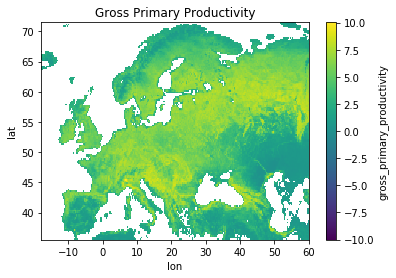

In [196]:
gpp_xr = create_xarray(gpp_df, variable)

fig, ax = plt.subplots()

gpp_xr[variable].plot.imshow(ax=ax, cmap='viridis', robust=False)
ax.set_title('Gross Primary Productivity')
plt.show()

In [197]:
gpp_df = create_df(subset, variable='gross_primary_productivity')
lst_df = create_df(subset, variable='land_surface_temperature')

var_df = gpp_df.merge(lst_df)
var_df = var_df.dropna()

Y = var_df['land_surface_temperature'].values
X = var_df['gross_primary_productivity'].values
lat = var_df['lat']
lon = var_df['lon']

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Extract Data with time as dimension

In [152]:
def get_time_df(xarray, var='gross_primary_productivity'):
    
    # convert to numpy array (Spatial x Time)
    xr_df = subset[var].where(subset.mask==1).to_dataframe(var).dropna()
    
    # drop max
    xr_dr = xr_df.drop('mask', 1)
    
    # Remove duplicates
    xr_df = xr_df.unstack(level=0)
    xr_df = xr_df.reset_index().pivot_table(index=range(xr_df.shape[0]), values=[var, 'lat', 'lon'],)
    
    return xr_df

In [98]:
gpp_df = get_time_df(subset, var='gross_primary_productivity')
lst_df = get_time_df(subset, var='land_surface_temperature')

var_df = gpp_df.merge(lst_df)
var_df = var_df.dropna()


In [136]:
Y = var_df['land_surface_temperature'].values
X = var_df['gross_primary_productivity'].values
lat = var_df['lat']
lon = var_df['lon']


In [102]:
X.shape

(12049, 11)

# HSIC

#### Subset

In [275]:
n_sub_samples = 10000
X_sub, _, Y_sub, _ = train_test_split(X, Y, train_size=n_sub_samples, random_state=123)
lat_sub, _, lon_sub, _ = train_test_split(lat, lon, train_size=n_sub_samples, random_state=123)
print(X_sub.shape, Y_sub.shape)
print(lat_sub.shape, lon_sub.shape)

(10000,) (10000,)
(10000,) (10000,)


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [276]:
%%time

hsic_model = HSIC(kernel='rbf', random_state=1234)

hsic_model.fit(X_sub[:, None], Y_sub[:, None]);

CPU times: user 5min 23s, sys: 19 s, total: 5min 42s
Wall time: 51 s


In [277]:
print(f"HSIC: {hsic_model.hsic_value:.4f}")

HSIC: 0.0525


#### Derivative HSIC

In [278]:
%%time
derX, derY = hsic_model.derivative()

CPU times: user 10min 54s, sys: 31 s, total: 11min 25s
Wall time: 1min 31s


In [279]:
print(derX.shape, derY.shape)

(10000, 1) (10000, 1)


#### Sensitivity

In [280]:
%%time

mod_sens = np.sqrt(np.abs(derX).mean(axis=1)**2 + np.abs(derY).mean(axis=1)**2)

ang_sens = np.arctan( np.abs(derY).mean(axis=1) / np.abs(derX).mean(axis=1))

CPU times: user 0 ns, sys: 952 µs, total: 952 µs
Wall time: 680 µs


#### Visualization

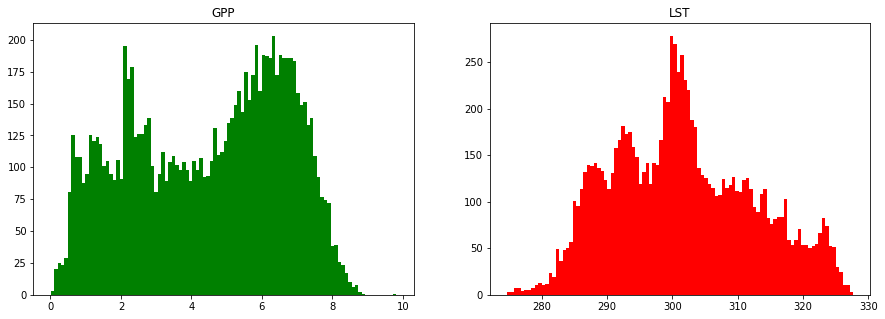

In [281]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].hist(X_sub, bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y_sub, bins=100, color='red')
ax[1].set_title('LST')

plt.show()

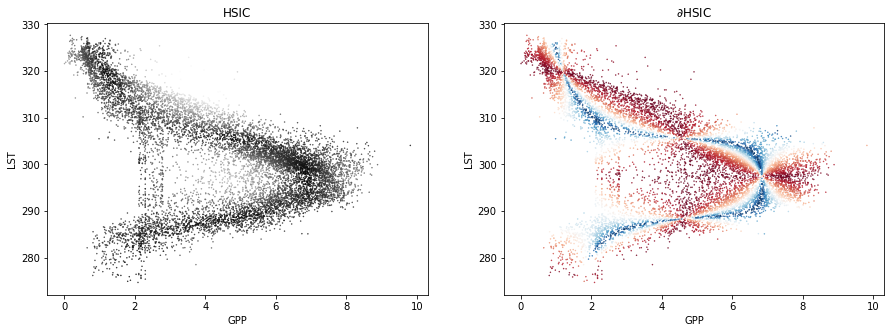

In [282]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].scatter(X_sub, Y_sub, c=mod_sens, cmap=plt.cm.get_cmap('gray'), s=0.2)
ax[0].set_xlabel('GPP')
ax[0].set_ylabel("LST")
ax[0].set_title('HSIC')

ax[1].scatter(X_sub, Y_sub, c=ang_sens, cmap=plt.cm.get_cmap('RdBu'), s=0.2)
ax[1].set_xlabel('GPP')
ax[1].set_ylabel("LST")
ax[1].set_title(r'$\partial$HSIC')
plt.show()

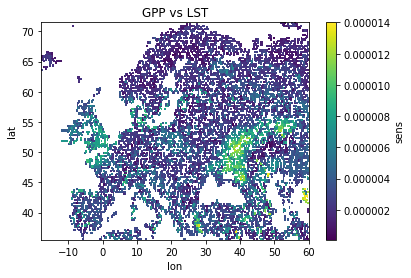

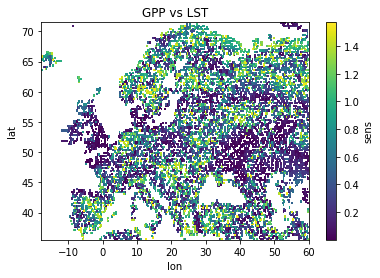

In [283]:
vis_df = pd.DataFrame({
    'lat': lat_sub,
    'lon': lon_sub,
    'sens': mod_sens,
})

# def create_xarray(xr_df, variable='gross_primary_productivity'):
    
#     xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
#     return xr_df.to_xarray()

vis_xr = create_xarray(vis_df, variable='sens')

fig, ax = plt.subplots(nrows=1)

vis_xr['sens'].plot.pcolormesh(ax=ax, cmap='viridis', robust=False)
ax.set_title('GPP vs LST')
plt.show()


vis_df = pd.DataFrame({
    'lat': lat_sub,
    'lon': lon_sub,
    'sens': ang_sens,
})

# def create_xarray(xr_df, variable='gross_primary_productivity'):
    
#     xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
#     return xr_df.to_xarray()

vis_xr = create_xarray(vis_df, variable='sens')

fig, ax = plt.subplots(nrows=1)

vis_xr['sens'].plot.pcolormesh(ax=ax, cmap='viridis', robust=False)
ax.set_title('GPP vs LST')
plt.show()

## RHSIC

In [257]:
%%time

rhsic_model = RHSIC(kernel='rbf', n_features=1000, random_state=1234)

rhsic_model.fit(X[:, None], Y[:, None]);

CPU times: user 40.4 s, sys: 14.5 s, total: 54.9 s
Wall time: 26.5 s


In [258]:
print(f"RHSIC: {rhsic_model.hsic_value:.4f}")

RHSIC: 0.0000


### Derivative

In [259]:
%%time
derX, derY = rhsic_model.derivative()

CPU times: user 9min 35s, sys: 2min 54s, total: 12min 29s
Wall time: 1min 47s


In [260]:
print(derX.shape, derY.shape)

(27997, 1) (27997, 1)


### Sensitivity

In [261]:
%%time

mod_sens = np.sqrt(np.abs(derX).mean(axis=1)**2 + np.abs(derY).mean(axis=1)**2)

ang_sens = np.arctan( np.abs(derY).mean(axis=1) / np.abs(derX).mean(axis=1))

CPU times: user 1.23 ms, sys: 0 ns, total: 1.23 ms
Wall time: 1.04 ms


## Plot Results

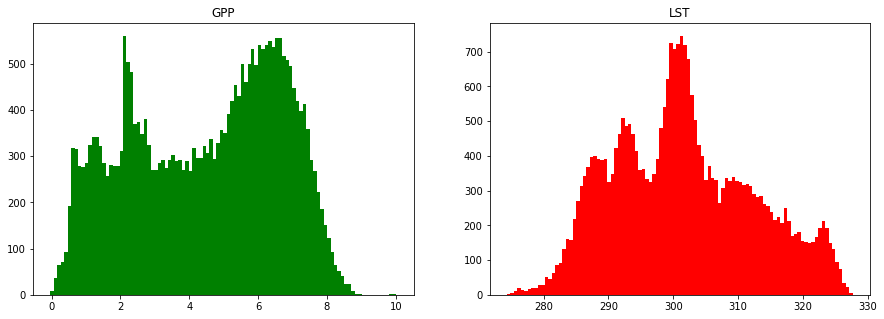

In [262]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X, bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y, bins=100, color='red')
ax[1].set_title('LST')

plt.show()

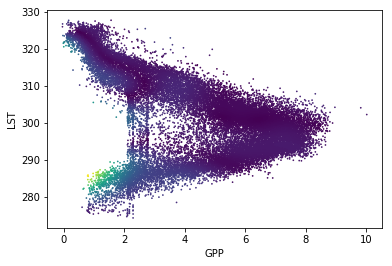

In [263]:
fig, ax = plt.subplots()

ax.scatter(X, Y, c=mod_sens, s=0.5)
ax.set_xlabel('GPP')
ax.set_ylabel('LST')
plt.show()

### Direction

Converting Cartesian to Polar Coordinates

* $r = \sqrt{x^2 + y^2}$
* $\theta = \arctan{\frac{y}{x}}$

Converting Polar to Cartesian Coordinates

* $x = r\cos{\theta}$
* $y=r\sin{\theta}$

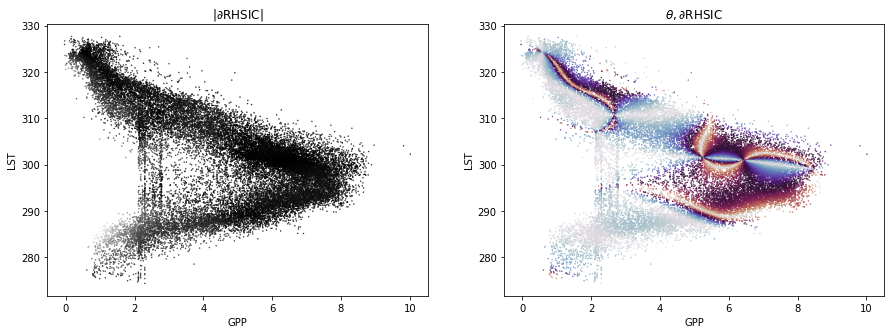

In [267]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].scatter(X, Y, c=mod_sens, cmap=plt.cm.get_cmap('gray'), s=0.2)
ax[0].set_xlabel('GPP')
ax[0].set_ylabel("LST")
ax[0].set_title(r'|$\partial$RHSIC|')

ax[1].scatter(X, Y, c=ang_sens, cmap=plt.cm.get_cmap('twilight'), s=0.2)
ax[1].set_xlabel('GPP')
ax[1].set_ylabel("LST")
ax[1].set_title(r'$\theta,\partial$RHSIC')
plt.show()

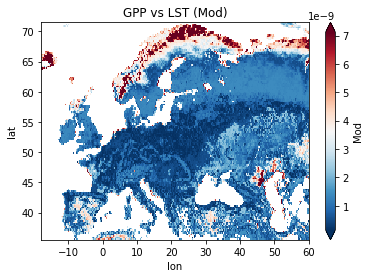

In [274]:
vis_df = pd.DataFrame({
    'lat': lat,
    'lon': lon,
    'sens': mod_sens
})

# def create_xarray(xr_df, variable='gross_primary_productivity'):
    
#     xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
#     return xr_df.to_xarray()

vis_xr = create_xarray(vis_df, variable='sens')

fig, ax = plt.subplots()

vis_xr['sens'].plot.imshow(ax=ax, cmap='RdBu_r', robust=True,
                           cbar_kwargs={'label': 'Mod'})
ax.set_title('GPP vs LST (Mod)')
plt.show()

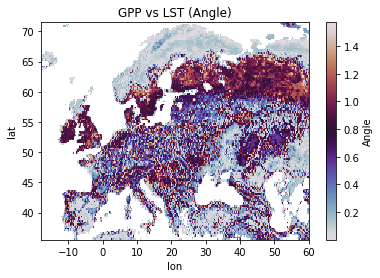

In [273]:
vis_df = pd.DataFrame({
    'lat': lat,
    'lon': lon,
    'sens': ang_sens
})

# def create_xarray(xr_df, variable='gross_primary_productivity'):
    
#     xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
#     return xr_df.to_xarray()

vis_xr = create_xarray(vis_df, variable='sens')

fig, ax = plt.subplots()

vis_xr['sens'].plot.imshow(ax=ax, cmap='twilight', robust=False,
                           cbar_kwargs={'label': 'Angle'})
ax.set_title('GPP vs LST (Angle)')
plt.show()